In [1]:
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [2]:
!pip install git+https://github.com/Julien2048/NLP_Project_OOD.git
!git clone https://github.com/Julien2048/NLP_Project_OOD
!pip install -r NLP_Project_OOD/requirements.txt

In [ ]:
%cd gdrive/MyDrive/NLP_Project_OOD/distilbert
!rm /usr/local/lib/python3.8/dist-packages/transformers/models/distilbert/modeling_distilbert.py
!cp modeling_distilbert.py /usr/local/lib/python3.8/dist-packages/transformers/models/distilbert/

!rm /usr/local/lib/python3.8/dist-packages/transformers/models/distilbert/__init__.py
!cp __init__.py /usr/local/lib/python3.8/dist-packages/transformers/models/distilbert/
%cd ..

%cd transformers
!rm /usr/local/lib/python3.8/dist-packages/transformers/__init__.py
!cp __init__.py /usr/local/lib/python3.8/dist-packages/transformers/
%cd ..
%cd ..
%cd ..
%cd ..

In [ ]:
!mkdir ~/.kaggle/ 
!cp kaggle.json ~/.kaggle/ # The kaggle.json is a file download from kaggle with your API codes (each has one to login)
!chmod 600 ~/.kaggle/kaggle.json 
!kaggle datasets download -d nltkdata/movie-review
!unzip /content/movie-review.zip -d /content/

In [ ]:
gdown.download("http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", output="aclImdb_v1.tar.gz", quiet=False)
!tar xzf /content/aclImdb_v1.tar.gz

In [7]:
import torch

In [8]:
from nlp_project.data_loader import IMDBDataset, MovieReviewDataset, MNLIDataset, CreateDataset
from nlp_project.OOD_detector import Mahalanobis
from nlp_project.metrics import ResultsOOD
from nlp_project.BERT_adaptation import TokenizeData, DistilBertClassifier

# Load Datasets

## Load IMDB Dataset

#### Download IMDB Data

In [9]:
get_imdb = IMDBDataset()
imdb_train_texts, imdb_test_texts, imdb_train_labels, imdb_test_labels = get_imdb.get_dataset()
get_imdb.save_labels()
get_imdb.save_texts()

#### Load IMDB Datasets

In [ ]:
get_imdb = IMDBDataset()
imdb_train_texts, imdb_test_texts = get_imdb.load_texts("/content/gdrive/MyDrive/NLP_Project_OOD/data/imdb/")
imdb_train_labels, imdb_test_labels = get_imdb.load_labels("/content/gdrive/MyDrive/NLP_Project_OOD/data/imdb/")

## Load Movie Review Dataset

#### Download Movie Review Data

In [10]:
get_movie = MovieReviewDataset()
movie_review_train_texts, movie_review_test_texts, movie_review_train_labels, movie_review_test_labels = get_movie.get_dataset()
get_movie.save_labels()
get_movie.save_texts()

#### Load Movie Review Datasets

In [ ]:
get_movie = MovieReviewDataset()
movie_review_train_texts, movie_review_test_texts = get_movie.load_texts("/content/gdrive/MyDrive/NLP_Project_OOD/data/movie_review/")

## Load MNLI Dataset

#### Download MNLI Dataset

In [ ]:
mnli = MNLIDataset()
mnli_test_texts = mnli.get_dataset()
mnli.save_texts()

#### Load MNLI Datasets

In [ ]:
mnli = MNLIDataset()
mnli_test_texts = mnli.load_texts("/content/gdrive/MyDrive/NLP_Project_OOD/data/mnli/")

# Prelogits extraction

In [24]:
# Check if a GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## Tokenize data

In [25]:
NB_TEXTS_TRAIN = 1600
NB_TEXTS_TEST = 400

#### Create tokens

In [28]:
tokenizer = TokenizeData()
imdb_input_ids_train, imdb_attention_masks_train = tokenizer(imdb_train_texts, "imdb", "train", 10000)
tokenizer.save_tokens()

imdb_input_ids_test, imdb_attention_masks_test = tokenizer(imdb_test_texts, "imdb", "test", NB_TEXTS_TEST)
tokenizer.save_tokens()

movie_review_input_ids_test, movie_review_attention_masks_test = tokenizer(movie_review_test_texts, "movie_review", "test", NB_TEXTS_TEST)
tokenizer.save_tokens()

mnli_input_ids_test, mnli_attention_masks_test = tokenizer(mnli_test_texts, "mnli", "test", NB_TEXTS_TEST)
tokenizer.save_tokens()

In [30]:
mnli_input_ids_test.shape

torch.Size([400, 103])

#### Load Tokens

In [ ]:
tokenizer = TokenizeData(model=None)
imdb_input_ids_train, imdb_attention_masks_train = tokenizer.load_tokens("imdb", "train", path="/content/gdrive/MyDrive/NLP_Project_OOD/distilbert_tokens/imdb/")
imdb_input_ids_test, imdb_attention_masks_test  = tokenizer.load_tokens("imdb", "test", path="/content/gdrive/MyDrive/NLP_Project_OOD/distilbert_tokens/imdb/")

movie_review_input_ids_test, movie_review_attention_masks_test = tokenizer.load_tokens("movie_review", "test", path="/content/gdrive/MyDrive/NLP_Project_OOD/distilbert_tokens/movie_review/")
mnli_input_ids_test, mnli_attention_masks_test = tokenizer.load_tokens("mnli", "test", path="/content/gdrive/MyDrive/NLP_Project_OOD/distilbert_tokens/mnli/")

In [21]:
print("Shape IMDB Train Dataset: ", imdb_input_ids_train.shape)
print("Shape IMDB Test Dataset: ", imdb_input_ids_test.shape)
print("Shape Movie Review Test Dataset: ", movie_review_input_ids_test.shape)
print("Shape MNLI Test Dataset: ", movie_review_input_ids_test.shape)

torch.Size([10000, 512]) torch.Size([400, 512])
torch.Size([1600, 512]) torch.Size([400, 512])


## Train the model

In [31]:
# Create the train, validation and test sets
imdb_encodings_train = {'input_ids':imdb_input_ids_train,
                      'attention_mask':imdb_attention_masks_train}
imdb_encodings_test = {'input_ids':imdb_input_ids_test,
                      'attention_mask':imdb_attention_masks_test}

imdb_train_dataset = CreateDataset(imdb_encodings_train, imdb_train_labels[:10000])
imdb_test_dataset = CreateDataset(imdb_encodings_test, imdb_test_labels[:NB_TEXTS_TEST])

In [32]:
# CONSTANTS
BATCH_SIZE = 32
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.06
LEARNING_RATE = 1e-5
NUM_EPOCHS = 3
LOG_STEPS = 100

### Train classifier

In [39]:
model = DistilBertClassifier(device=device, training=True, num_epochs=4)
model.train_model(imdb_train_dataset, imdb_test_dataset)
model.save_pretrained_model("distilbert")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassificationPreLogits: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassificationPreLogits from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassificationPreLogits from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassificationPreLogits were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.wei

Step,Training Loss
100,0.636700
200,0.295200
300,0.268900
400,0.219700
500,0.194200
600,0.194300
700,0.163400


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
/usr/local/lib/python3.8/dist-packages/nlp_project/data_loader.py:183: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss
100,0.636700
200,0.295200
300,0.268900
400,0.219700
500,0.194200
600,0.194300
700,0.163400
800,0.143500
900,0.149700
1000,0.130600


Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
/usr/local/lib/python3.8/dist-packages/nlp_project/data_loader.py:183: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Training completed. Do not forget to share your model on huggingface.co/models =)


Configuration saved in model_trained/distilbert/config.json
Model weights saved in model_trained/distilbert/pytorch_model.bin


### Load Classifier

In [58]:
# model_trained = DistilBertClassifier(device=device, training=False)
# model_trained.load_pretrained_model("model_trained/distilbert/")

## Get Logits and Prelogits 

### Create Logits and Prelogits

In [47]:
imdb_prelogits_train, imdb_logits_train = model.get_prelogit_logit(imdb_input_ids_train.to(device), imdb_attention_masks_train.to(device), "imdb", "train", save=True)
imdb_prelogits_test, imdb_logits_test = model.get_prelogit_logit(imdb_input_ids_test.to(device), imdb_attention_masks_test.to(device), "imdb", "test", save=True)

movie_review_prelogits_test, movie_review_logits_test = model.get_prelogit_logit(movie_review_input_ids_test.to(device), movie_review_attention_masks_test.to(device), "movie_review", "test", save=True)
mnli_prelogits_test, mnli_logits_test = model.get_prelogit_logit(mnli_input_ids_test.to(device), mnli_attention_masks_test.to(device), "mnli", "test", save=True)

### Load Logits and Prelogits

In [ ]:
imdb_prelogits_train, imdb_logits_train = model.load_prelogit_logit("imdb", "train", path="/content/gdrive/MyDrive/NLP_Project_OOD/logits-prelogits/imdb-mr-mnli/")
imdb_prelogits_test, imdb_logits_test = model.load_prelogit_logit("imdb", "test", path="/content/gdrive/MyDrive/NLP_Project_OOD/logits-prelogits/imdb-mr-mnli/")

movie_review_prelogits_test, movie_review_logits_test = model.load_prelogit_logit("movie_review", "test", path="/content/gdrive/MyDrive/NLP_Project_OOD/logits-prelogits/imdb-mr-mnli/")
mnli_prelogits_test, mnli_logits_test = model.load_prelogit_logit( "mnli", "test", path="/content/gdrive/MyDrive/NLP_Project_OOD/logits-prelogits/imdb-mr-mnli/")

# Computing OOD
## Mahalanobis Score

In [48]:
maha_imdb_mr = Mahalanobis(
    imdb_prelogits_train,
    imdb_prelogits_test,
    movie_review_prelogits_test,
    imdb_train_labels[:10000],
    substract_mean = False,
    normalize_to_unity = False,
    substract_train_distance = False,
    norm_name = "L1"
)
onehots_imdb_mr, scores_imdb_mr = maha_imdb_mr()

Average value of cov_inv matrix : 47411429.92583973
Average distance between cov_inv*cov and identity matrix : 0.0014670945708089454


AUROC : 51.92 %


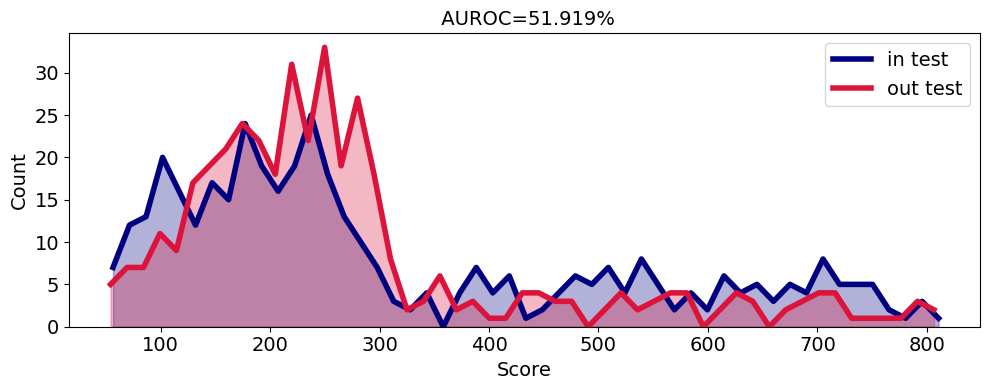

In [49]:
results_imdb_mr = ResultsOOD(onehots_imdb_mr, scores_imdb_mr)
results_imdb_mr()

In [50]:
maha_imdb_mnli = Mahalanobis(
    imdb_prelogits_train,
    imdb_prelogits_test,
    mnli_prelogits_test,
    imdb_train_labels[:10000],
    substract_mean = False,
    normalize_to_unity = False,
    substract_train_distance = False,
    norm_name = "L1"
)
onehots_imdb_mnli, scores_imdb_mnli = maha_imdb_mnli()

Average value of cov_inv matrix : 47411429.92583973
Average distance between cov_inv*cov and identity matrix : 0.0014670945708089454


AUROC : 86.14 %


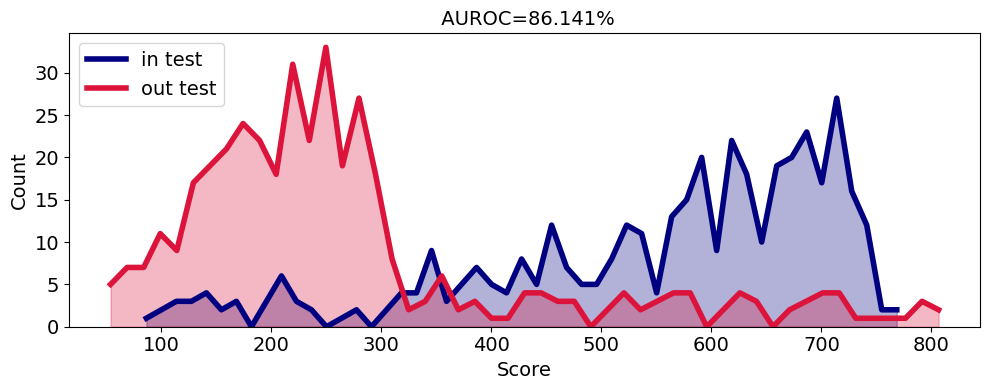

In [51]:
results_imdb_mnli = ResultsOOD(onehots_imdb_mnli, scores_imdb_mnli)
results_imdb_mnli()

## Maximum Softmax

In [52]:
def np_softmax(zs):
  exps = np.exp(zs-np.max(zs))
  return exps/np.sum(exps,axis=-1,keepdims=True)

AUROC : 58.49 %


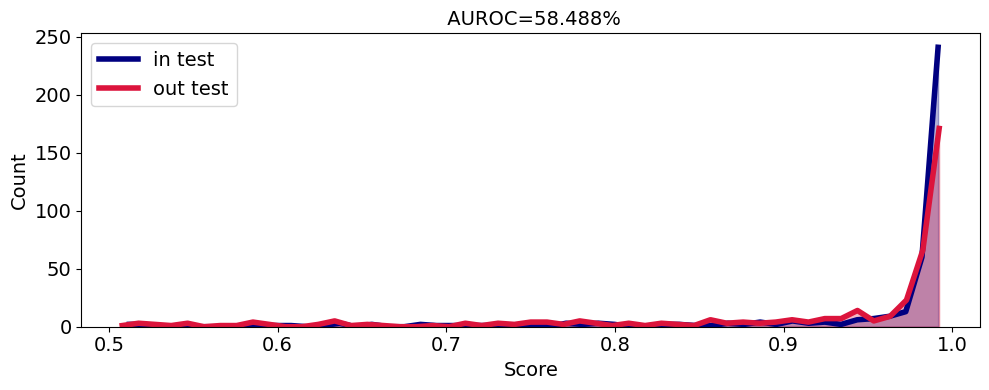

In [55]:
scores = np.array(
    np.concatenate([
     np.max(np_softmax(imdb_logits_test),axis=-1),
     np.max(np_softmax(movie_review_logits_test),axis=-1),
    ],axis=0)
)

onehots = np.array(
    [1]*len(imdb_logits_test)+[0]*len(movie_review_logits_test)
)

results = ResultsOOD(onehots, scores)
results()

AUROC : 93.11 %


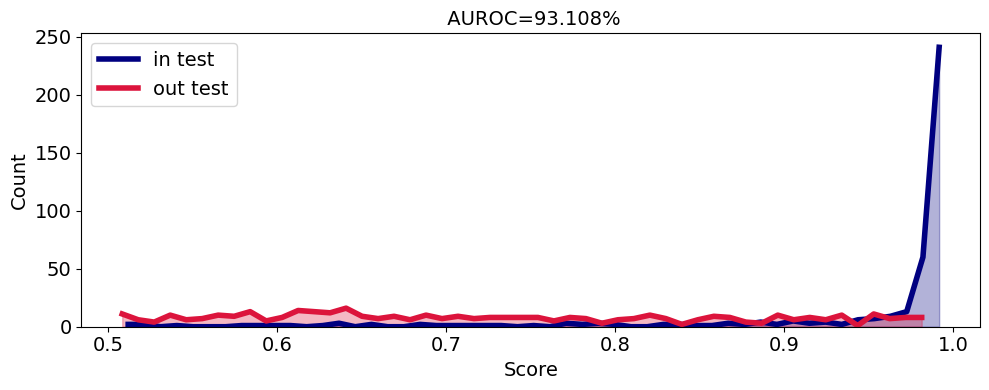

In [56]:
scores = np.array(
    np.concatenate([
     np.max(np_softmax(imdb_logits_test),axis=-1),
     np.max(np_softmax(mnli_logits_test),axis=-1),
    ],axis=0)
)

onehots = np.array(
    [1]*len(imdb_logits_test)+[0]*len(mnli_logits_test)
)

results = ResultsOOD(onehots, scores)
results()